In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

In [35]:
a = 0  #@param
b = 1  #@param

K = 3 #@param
N = 100

N_train = int(N/3*2)
mean = 1
var = 0.1 #@param

In [36]:
def phi(X, K):
  N = len(X)
  V = np.zeros((N, K))
  for j in range(K):
    V[:,j] = X**j
  return V 

In [37]:
theta_true = np.ones(K)
X = np.linspace(a, b, N)
V = phi(X, K)
e = np.random.normal(0, var, N)
Y = V @ theta_true + e

D = (X, Y)

In [38]:
idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:N_train]
test_idx = idx[N_train:]

Xtrain = X[train_idx]
Ytrain = Y[train_idx]
Xtest = X[test_idx]
Ytest = Y[test_idx]

Dtrain = (Xtrain, Ytrain)
Dtest = (Xtest, Ytest)

In [39]:
def grad_f_MLE(X, Y, theta):
    K = len(theta)
    phi_X = phi(X, K)
    return phi_X.T @ ((phi_X @ theta) - Y)

def grad_f_MAP(lam): 
    return lambda X, Y, theta: phi(X, len(theta)).T @ ((phi(X, len(theta)) @ theta) - Y) + 2 * lam * theta

In [40]:
def theta_ne_mle(phi_X, Y):
    return np.linalg.solve(phi_X.T @ phi_X, phi_X.T @ Y)

def theta_ne_map(phi_X, Y, lam, K):
    return np.linalg.solve(phi_X.T @ phi_X + (lam * np.identity(K)), phi_X.T @ Y) 

In [41]:
def gradient_descent(grad_f, x0, D, kmax=5000, tolf=1e-8, tolx=1e-8, alpha=1e-5):
    X, Y = D
    k = 0
    x_vals = np.zeros((kmax+1, int(x0.shape[0])))

    x_vals[k] = x0
        
    x_vals[-1, :] = 0.1

    while (k < kmax) and (np.linalg.norm(grad_f(X, Y, x_vals[k, :]), 2) > tolf) and (np.linalg.norm(x_vals[k, :] - x_vals[k-1, :], 2) > tolx):

        x_vals[k+1, :] = x_vals[k, :] - alpha * grad_f(X, Y, x_vals[k, :])
        k = k+1
    
    return x_vals[len(x_vals)-1, :]

In [42]:
def SGD(grad_f, w0, D, batch_size=16, n_epochs=80, alpha=1e-5):
    X, Y = D
    N = len(X)

    n_batch_per_epoch = N // batch_size
    tot_batch = n_epochs * n_batch_per_epoch

    w_val = np.zeros((tot_batch + 1, len(w0)))    
    w_val[0, :] = w0
    i = 1

    for epoch in range(1, n_epochs+1):
        x_copy = X
        y_copy = Y
        batch_idx = np.arange(N)
        np.random.shuffle(batch_idx)    
        
        for k in range(n_batch_per_epoch):
            batch = batch_idx[k * batch_size : (k + 1) * batch_size]       
            Mx = x_copy[batch]
            My = y_copy[batch]
            
            w = w0 - alpha * grad_f(Mx, My, w0)
            w0 = w
            w_val[i] = w
            i = i + 1

    return w_val[len(w_val)-1, :]


In [43]:
def MLE(D, K, optimization_tool):
    X, Y = D
    theta = None
    if optimization_tool == "NE":
        theta = theta_ne_mle(phi(X, K), Y)
    if optimization_tool == "GD":
        theta = gradient_descent(grad_f_MLE, np.ones((K,)), D)
    if optimization_tool == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(grad_f_MLE, w0, D)
    return theta 

def MAP(D, K, lam, optimization_tool):
    X, Y = D
    theta = None
    if optimization_tool == "NE":
        theta = theta_ne_map(phi(X, K), Y, lam, K)
    if optimization_tool == "GD":
        theta = gradient_descent(grad_f_MAP(lam), np.ones((K,)), D)
    if optimization_tool == "SGD":
        w0 = np.random.normal(mean, var, K)
        theta = SGD(grad_f_MAP(lam), w0, D)
    return theta

In [44]:
def compute_f_theta(X, K, theta):
    return phi(X, K) @ theta

def avg_error(theta, D):
    X, Y = D
    N = len(X)
    K = len(theta)
    return 1/N * (np.linalg.norm(compute_f_theta(X, K, theta) - Y)**2)

def err_theta_true(theta, theta_true):
    t = len(theta_true)
    l = len(theta)
    pad_true = np.pad(theta_true, (0, l-t), 'constant', constant_values=(0))
    return np.linalg.norm(theta - pad_true, 2) / np.linalg.norm(pad_true,2)

In [45]:
K_elements_mle = [1, 2, 3, 4, 6, 12, 15]
methods = ["NE", "GD", "SGD"]

thetas_mle_ne = []
thetas_mle_gd = []
thetas_mle_sgd = []

thetas_error_mle_ne = []
thetas_error_mle_gd = []
thetas_error_mle_sgd = []

train_errors_ne = []
test_errors_ne = []

train_errors_gd = []
test_errors_gd = []

train_errors_sgd = []
test_errors_sgd = []

for k in K_elements_mle:
  for m in methods:
    print(f"Computing k={k} for {m} ...")
    theta = MLE(Dtrain, k, m)
    if k > 3:
      theta_error = err_theta_true(theta, theta_true)
      if m == "NE":
        thetas_error_mle_ne.append(theta_error)
      elif m == "GD":
        thetas_error_mle_gd.append(theta_error)
      else:
        thetas_error_mle_sgd.append(theta_error)

    if m == "NE":
      thetas_mle_ne.append(theta)
      train_errors_ne.append(avg_error(theta, Dtrain))
      test_errors_ne.append(avg_error(theta, Dtest))
    elif m == "GD":
      thetas_mle_gd.append(theta)
      train_errors_gd.append(avg_error(theta, Dtrain))
      test_errors_gd.append(avg_error(theta, Dtest))
    else:
      thetas_mle_sgd.append(theta)
      train_errors_sgd.append(avg_error(theta, Dtrain))
      test_errors_sgd.append(avg_error(theta, Dtest))
  print("\n")

Computing k=1 for NE ...
Computing k=1 for GD ...
Computing k=1 for SGD ...


Computing k=2 for NE ...
Computing k=2 for GD ...
Computing k=2 for SGD ...


Computing k=3 for NE ...
Computing k=3 for GD ...
Computing k=3 for SGD ...


Computing k=4 for NE ...
Computing k=4 for GD ...
Computing k=4 for SGD ...


Computing k=6 for NE ...
Computing k=6 for GD ...
Computing k=6 for SGD ...


Computing k=12 for NE ...
Computing k=12 for GD ...
Computing k=12 for SGD ...


Computing k=15 for NE ...
Computing k=15 for GD ...
Computing k=15 for SGD ...




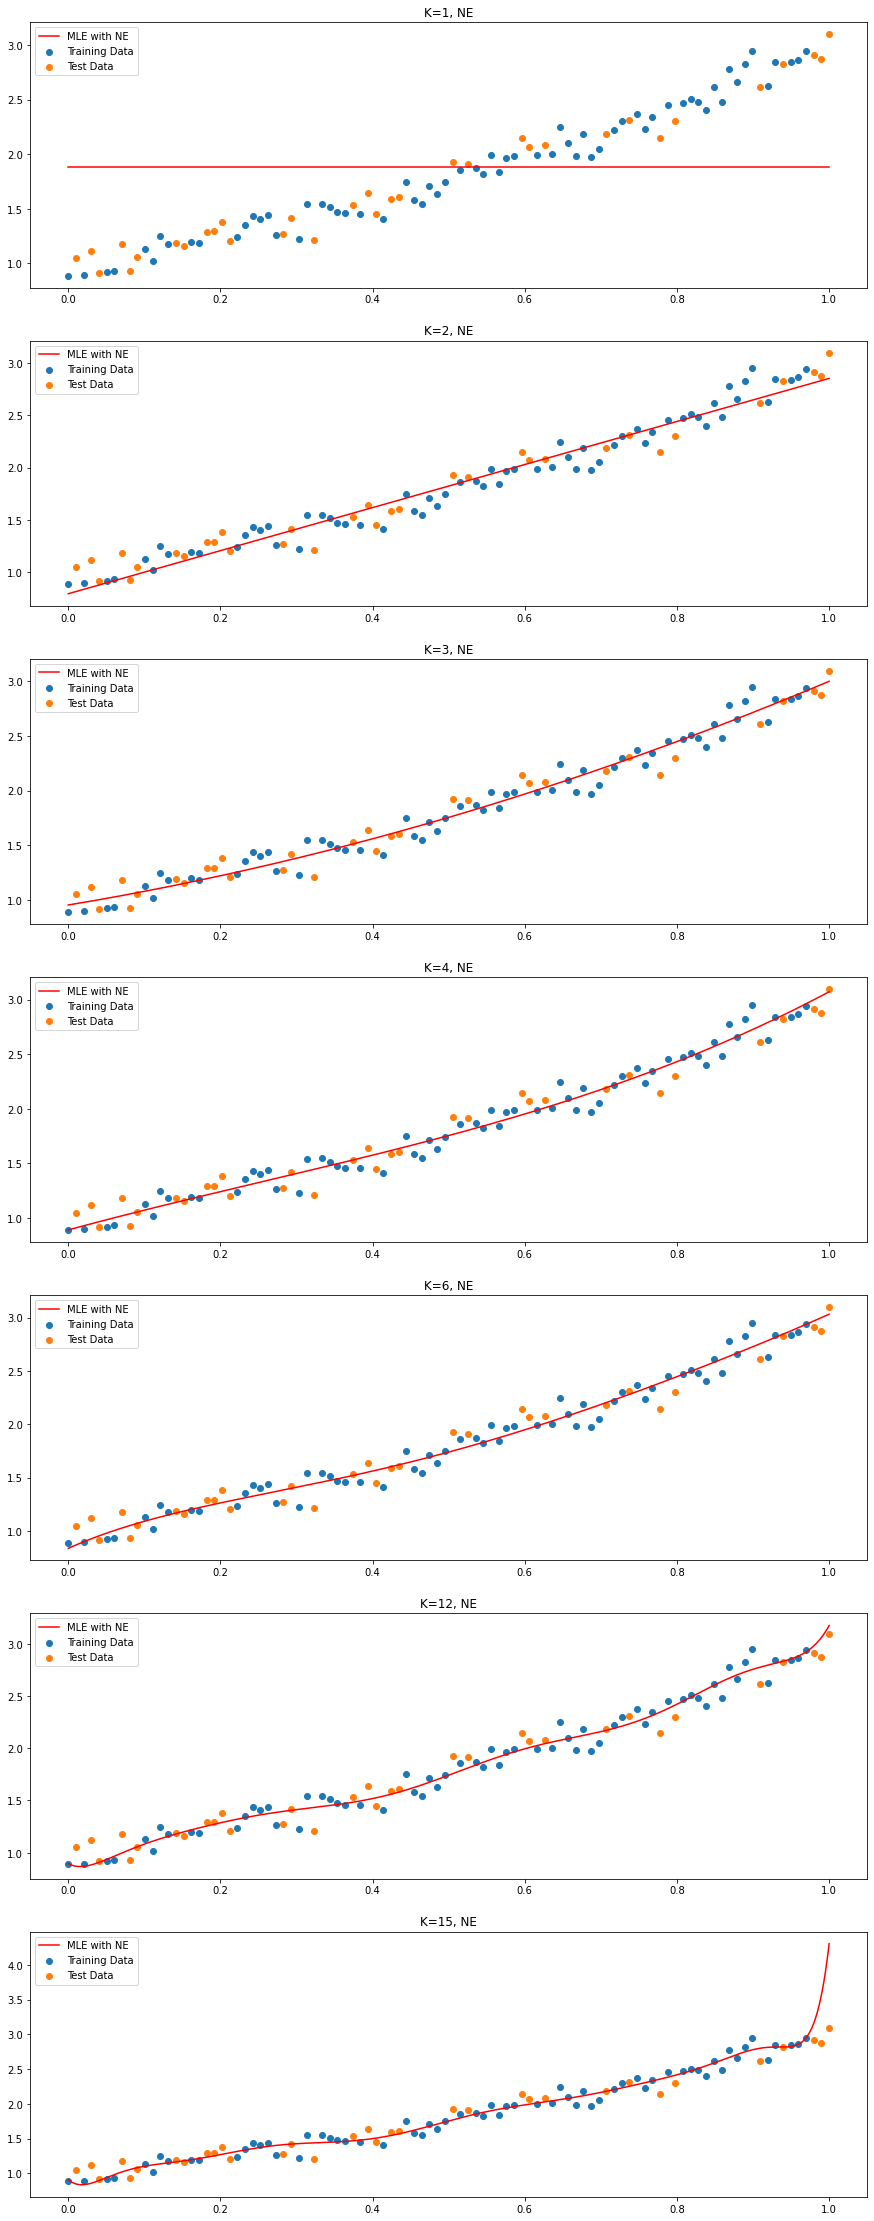

In [46]:
fig, ax = plt.subplots(len(K_elements_mle), figsize = (15, 40))

for i in range(len(K_elements_mle)):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(X_plot, K_elements_mle[i], thetas_mle_ne[i])
    ax[i].plot(X_plot, Y_plot, label = f"MLE with NE", color="red")
    ax[i].scatter(Xtrain, Ytrain, label="Training Data")
    ax[i].scatter(Xtest, Ytest, label = "Test Data")
    ax[i].set_title("K=" + str(K_elements_mle[i]) + ", NE")
    ax[i].legend()

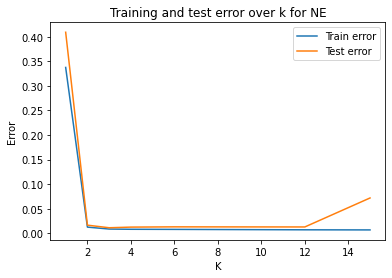

In [47]:
plt.plot(K_elements_mle, train_errors_ne, label = "Train error")
plt.plot(K_elements_mle, test_errors_ne, label = "Test error")
plt.legend()
plt.title("Training and test error over k for NE")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

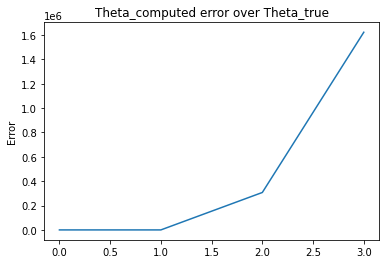

In [48]:
number_of_el = range(len(thetas_error_mle_ne))
plt.plot(number_of_el, thetas_error_mle_ne)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

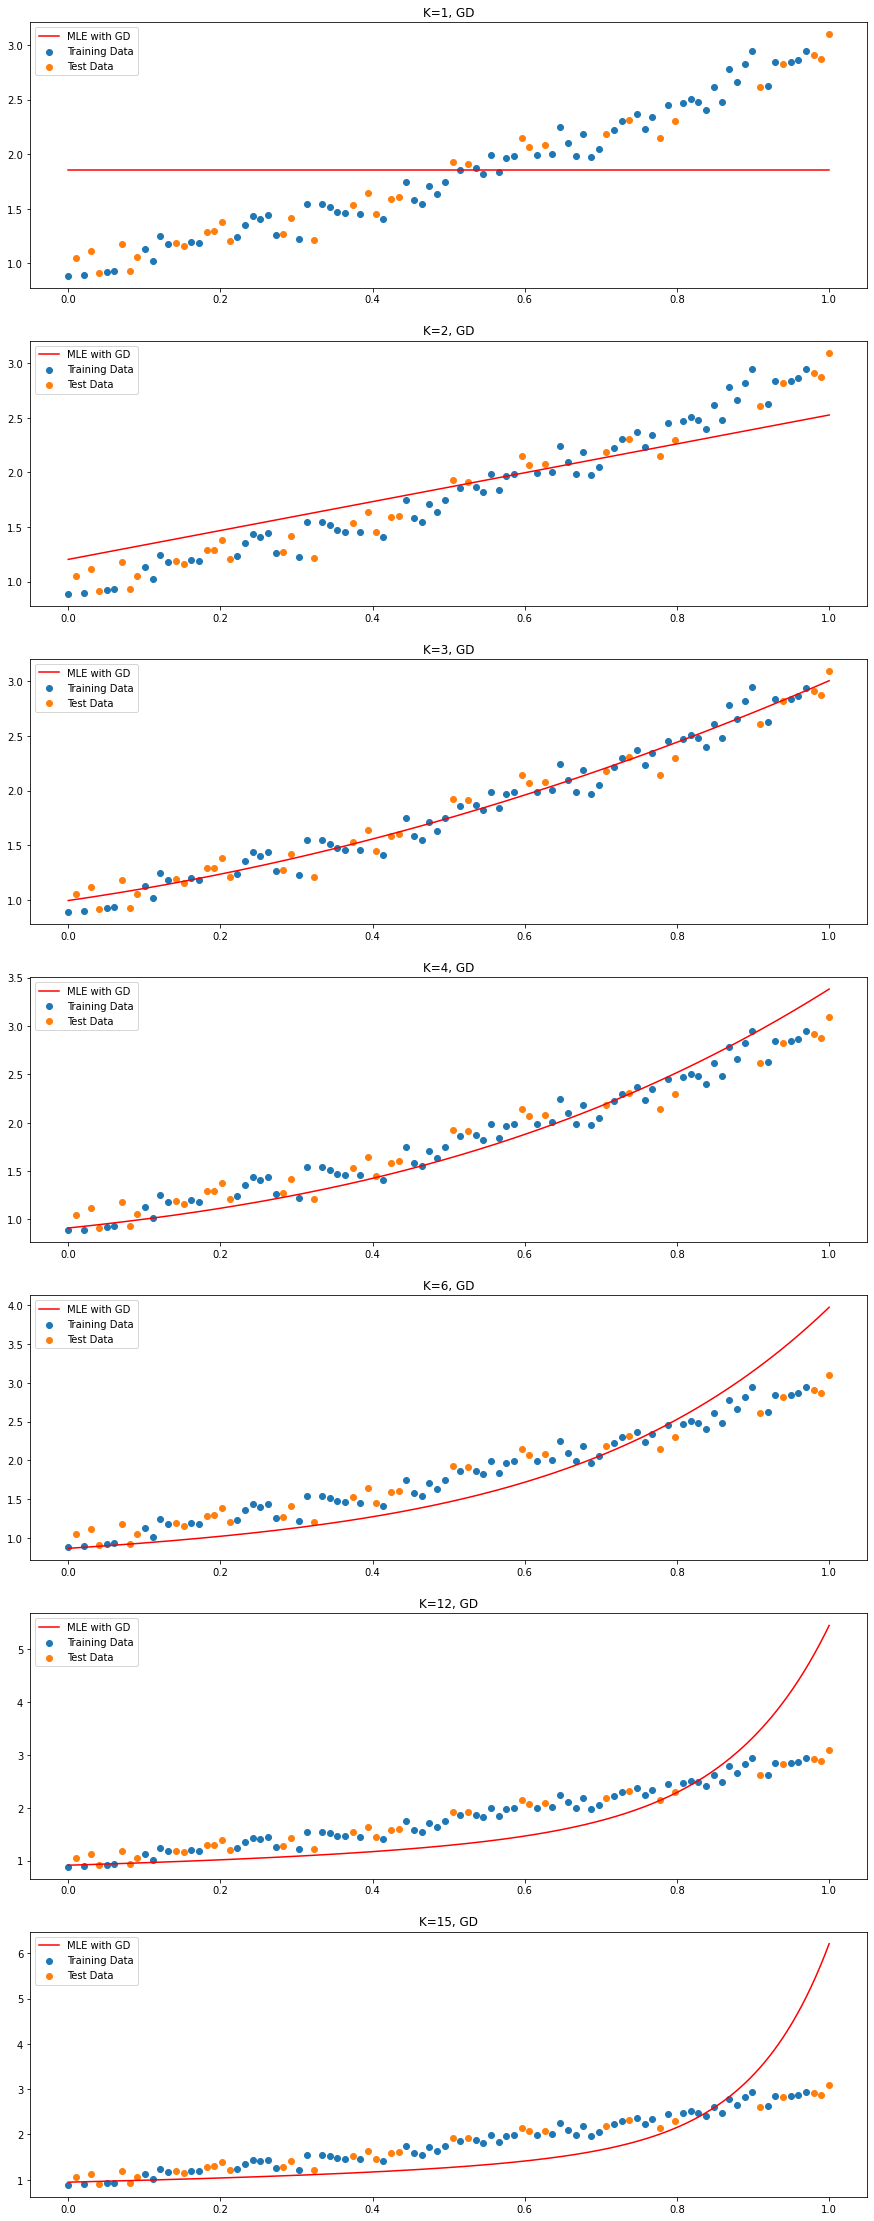

In [49]:
fig, ax = plt.subplots(len(K_elements_mle), figsize = (15, 40))

for i in range(len(K_elements_mle)):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(X_plot, K_elements_mle[i], thetas_mle_gd[i])
    ax[i].plot(X_plot, Y_plot, label = f"MLE with GD", color="red")
    ax[i].scatter(Xtrain, Ytrain, label="Training Data")
    ax[i].scatter(Xtest, Ytest, label = "Test Data")
    ax[i].set_title("K=" + str(K_elements_mle[i]) + ", GD")
    ax[i].legend()

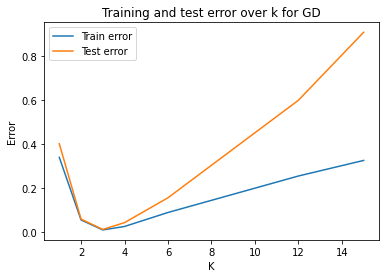

In [50]:
plt.plot(K_elements_mle, train_errors_gd, label = "Train error")
plt.plot(K_elements_mle, test_errors_gd, label = "Test error")
plt.legend()
plt.title("Training and test error over k for GD")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

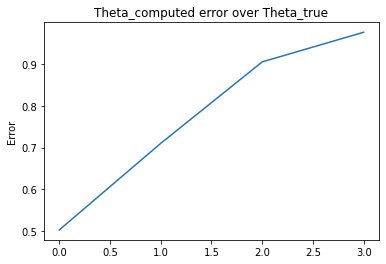

In [51]:
number_of_el = range(len(thetas_error_mle_gd))
plt.plot(number_of_el, thetas_error_mle_gd)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

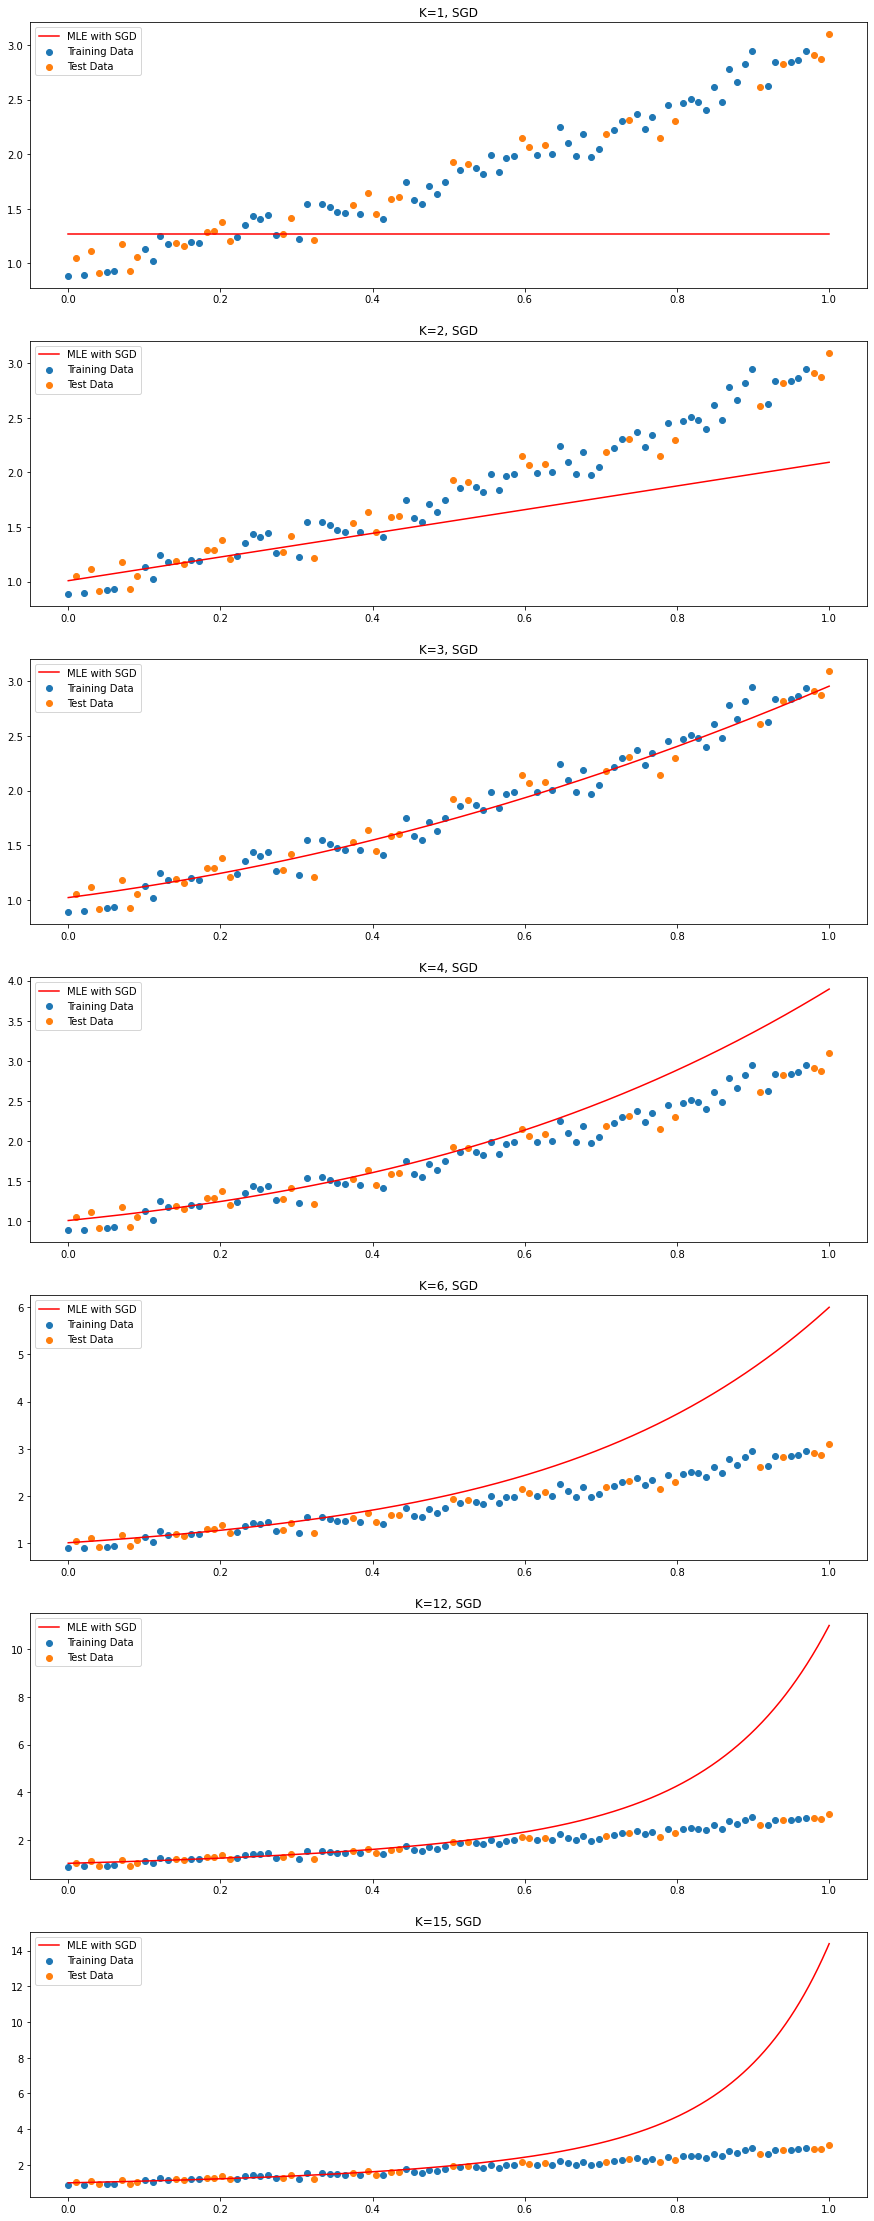

In [52]:
fig, ax = plt.subplots(len(K_elements_mle), figsize = (15, 40))

for i in range(len(K_elements_mle)):
    X_plot = np.linspace(a, b, 1000)
    Y_plot = compute_f_theta(X_plot, K_elements_mle[i], thetas_mle_sgd[i])
    ax[i].plot(X_plot, Y_plot, label = f"MLE with SGD", color="red")
    ax[i].scatter(Xtrain, Ytrain, label="Training Data")
    ax[i].scatter(Xtest, Ytest, label = "Test Data")
    ax[i].set_title("K=" + str(K_elements_mle[i]) + ", SGD")
    ax[i].legend()

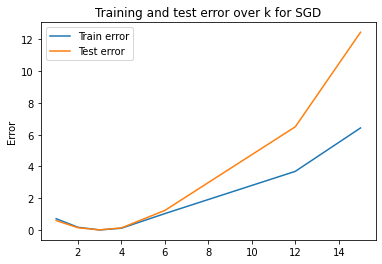

In [53]:
plt.plot(K_elements_mle, train_errors_sgd, label = "Train error")
plt.plot(K_elements_mle, test_errors_sgd, label = "Test error")
plt.legend()
plt.title("Training and test error over k for SGD")
plt.ylabel("Error")
plt.show()

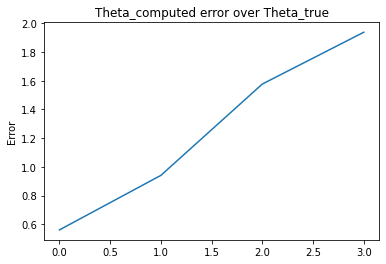

In [54]:
number_of_el = range(len(thetas_error_mle_sgd))
plt.plot(number_of_el, thetas_error_mle_sgd)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

In [55]:
K_elements_map = [2, 3, 4, 5, 6, 15]
lambdas = [0.5, 0.8, 1.2, 6, 10]
methods = ["NE", "GD", "SGD"]

thetas_map_ne = []
thetas_map_gd = []
thetas_map_sgd = []

thetas_error_map_ne = []
thetas_error_map_gd = []
thetas_error_map_sgd = []

train_errors_ne = []
test_errors_ne = []

train_errors_gd = []
test_errors_gd = []

train_errors_sgd = []
test_errors_sgd = []

for k in K_elements_map:
  for m in methods:
    thetas_map_lambda_ne = []
    thetas_map_lambda_gd = []
    thetas_map_lambda_sgd = []
    print(f"Computing k={k} for {m} ...")
    for lam in lambdas:
      print(f"Computing lambda={lam} ...")
      theta = MAP(Dtrain, k, lam, m)
      if k > 3:
        theta_error = err_theta_true(theta, theta_true)
        if m == "NE":
          thetas_error_map_ne.append(theta_error)
        elif m == "GD":
          thetas_error_map_gd.append(theta_error)
        else:
          thetas_error_map_sgd.append(theta_error)

      if m == "NE":
        thetas_map_lambda_ne.append(theta)
        train_errors_ne.append(avg_error(theta, Dtrain))
        test_errors_ne.append(avg_error(theta, Dtest))
      elif m == "GD":
        thetas_map_lambda_gd.append(theta)
        train_errors_gd.append(avg_error(theta, Dtrain))
        test_errors_gd.append(avg_error(theta, Dtest))
      else:
        thetas_map_lambda_sgd.append(theta)
        train_errors_sgd.append(avg_error(theta, Dtrain))
        test_errors_sgd.append(avg_error(theta, Dtest))
    if m == "NE":
      thetas_map_ne.append(thetas_map_lambda_ne)
    elif m == "GD":
      thetas_map_gd.append(thetas_map_lambda_gd)
    else:
      thetas_map_sgd.append(thetas_map_lambda_sgd)
    print("\n")

Computing k=2 for NE ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=2 for GD ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=2 for SGD ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=3 for NE ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=3 for GD ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=3 for SGD ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Computing lambda=6 ...
Computing lambda=10 ...


Computing k=4 for NE ...
Computing lambda=0.5 ...
Computing lambda=0.8 ...
Computing lambda=1.2 ...
Comp

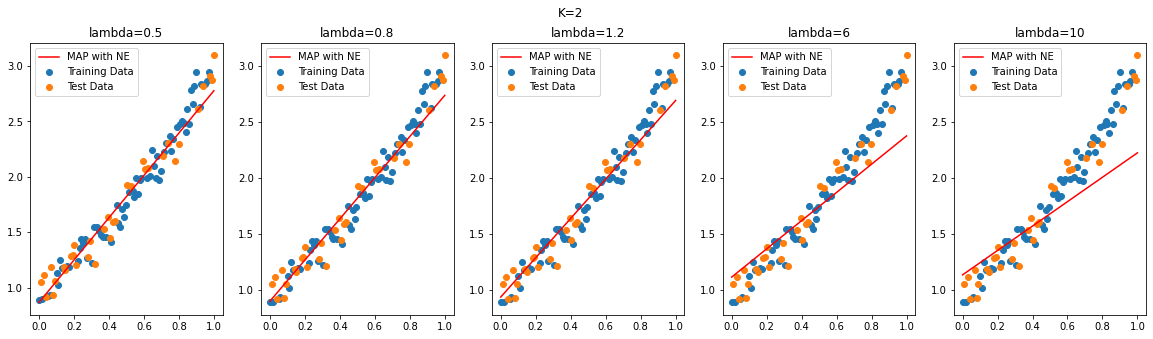

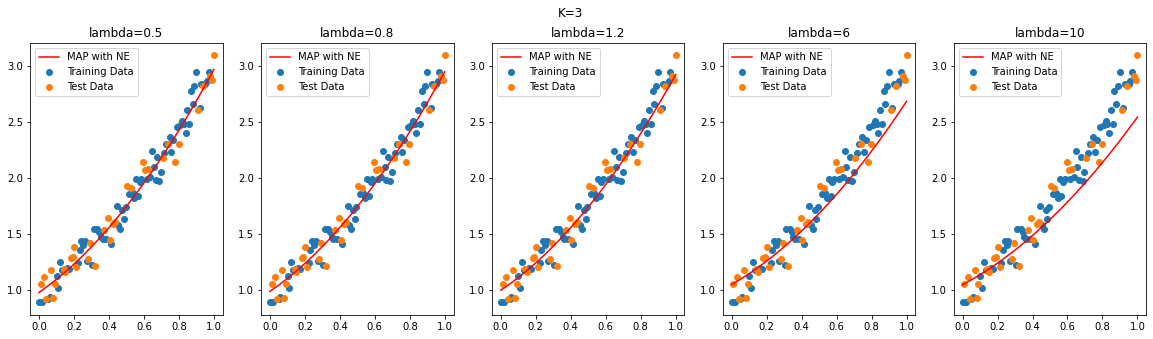

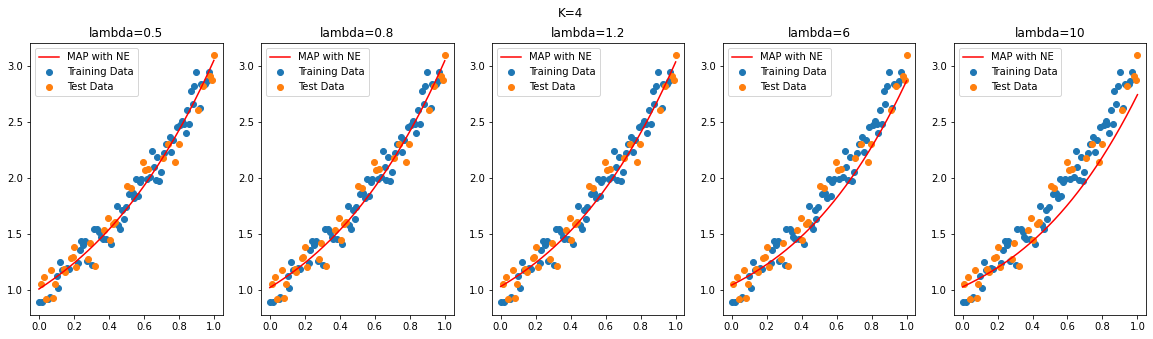

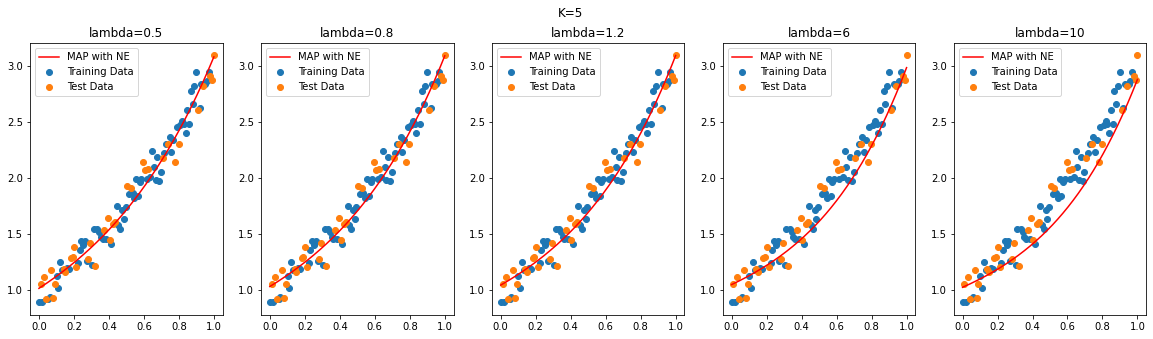

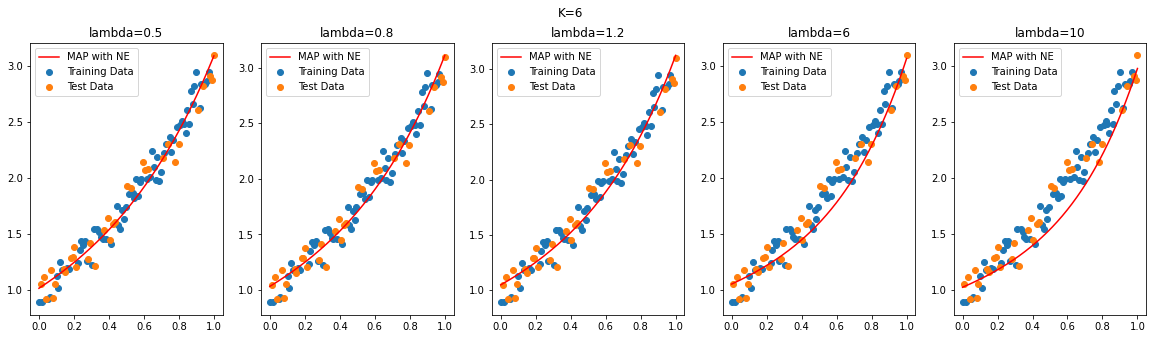

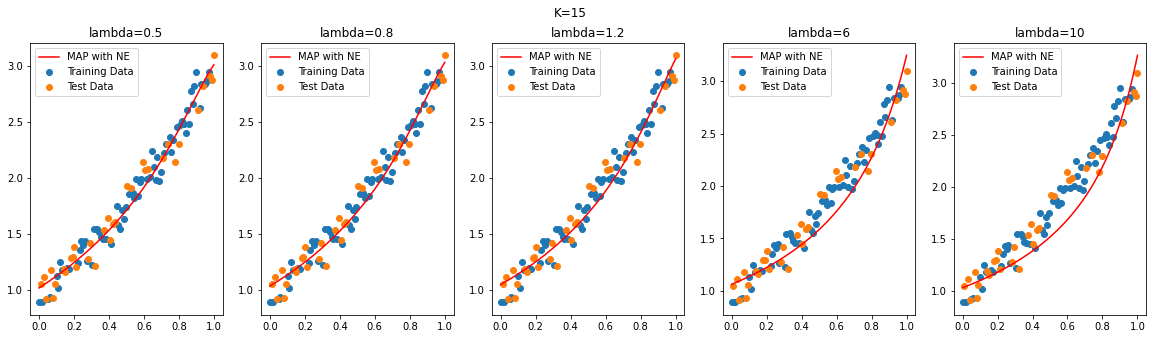

In [56]:
for i in range(len(K_elements_map)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_elements_map[i]}")
    for j in range(len((lambdas))):
      current_theta = thetas_map_ne[i][j]
      X_plot = np.linspace(a, b, 1000)
      Y_plot = compute_f_theta(X_plot, K_elements_map[i], current_theta)
      plt.subplot(1, 5, j+1)
      plt.plot(X_plot, Y_plot, label=f"MAP with NE", color="red")
      plt.scatter(Xtrain, Ytrain, label= "Training Data")
      plt.scatter(Xtest, Ytest, label="Test Data")
      plt.title(f"lambda={lambdas[j]}")
      plt.legend() 

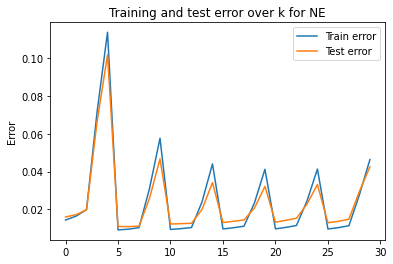

In [57]:
number_of_el = range(len(K_elements_map) * len(lambdas))
plt.plot(number_of_el, train_errors_ne, label = "Train error")
plt.plot(number_of_el, test_errors_ne, label = "Test error")
plt.legend()
plt.title("Training and test error over k for NE")
plt.ylabel("Error")
plt.show()

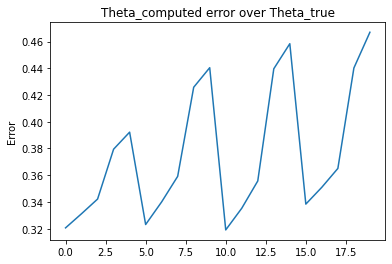

In [58]:
number_of_el = range(len(thetas_error_map_ne))
plt.plot(number_of_el, thetas_error_map_ne)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

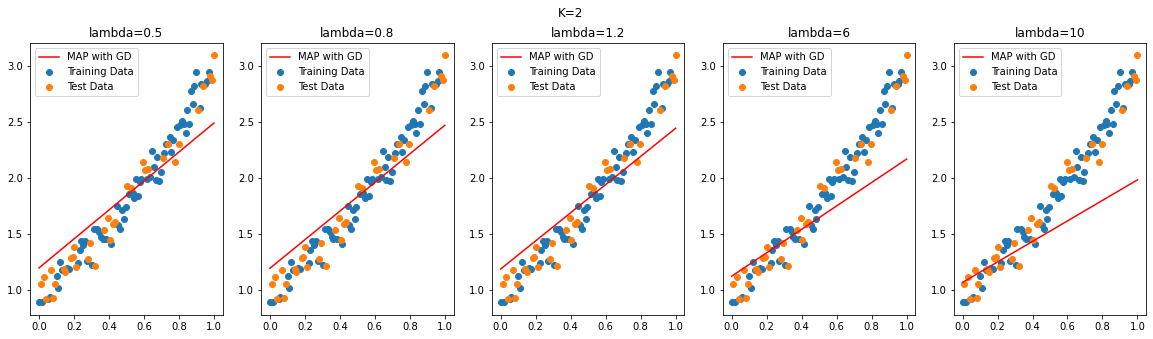

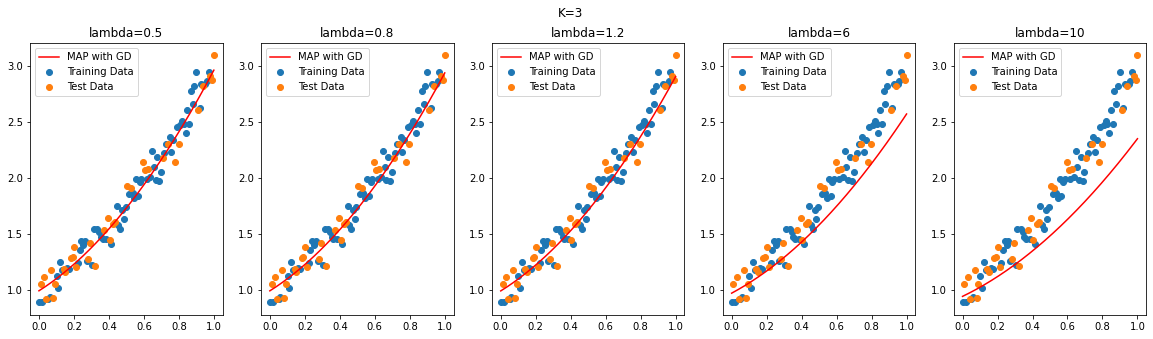

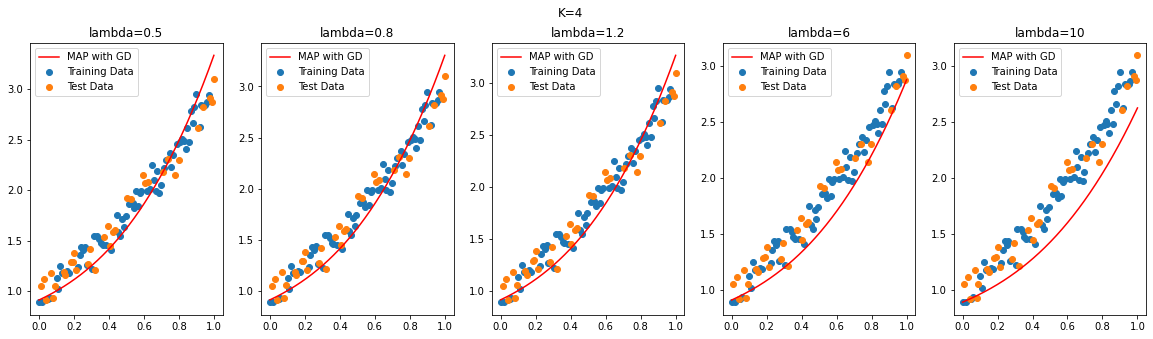

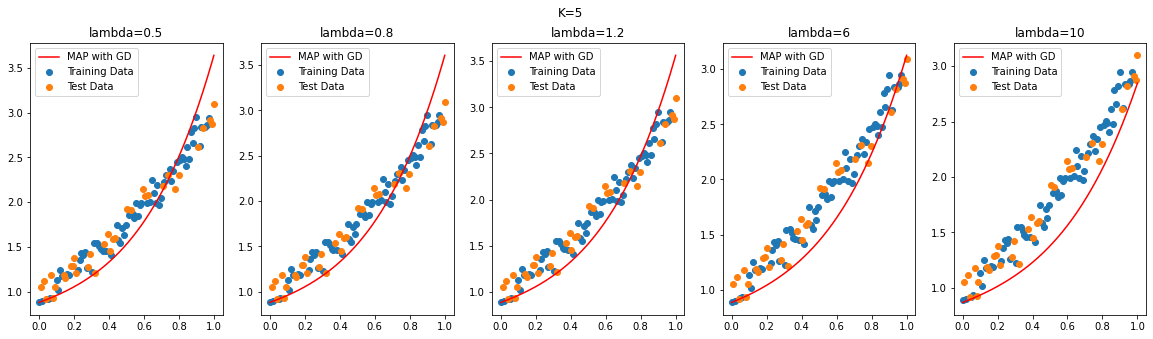

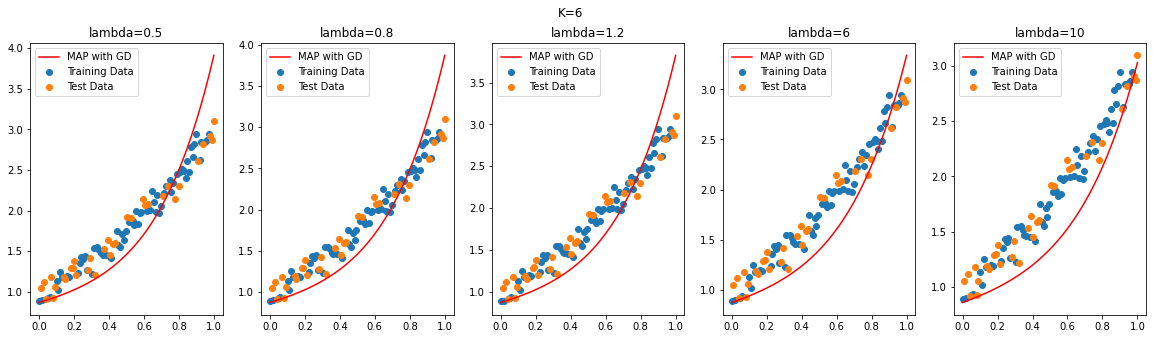

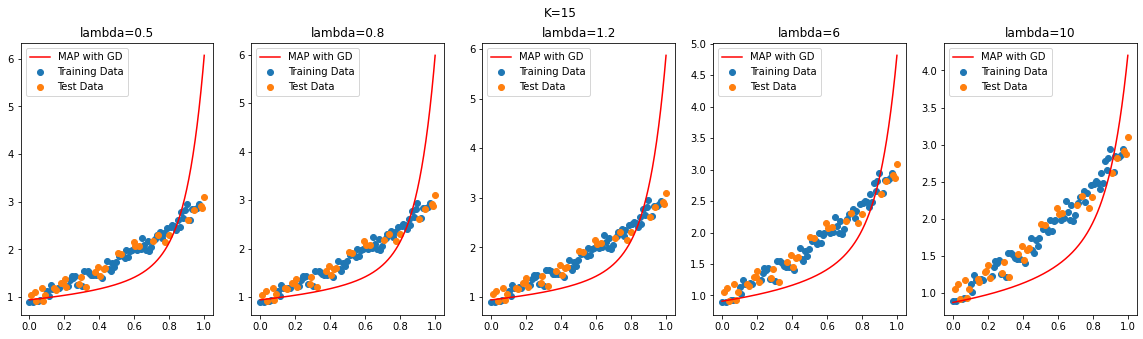

In [59]:
for i in range(len(K_elements_map)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_elements_map[i]}")
    for j in range(len((lambdas))):
      current_theta = thetas_map_gd[i][j]
      X_plot = np.linspace(a, b, 1000)
      Y_plot = compute_f_theta(X_plot, K_elements_map[i], current_theta)
      plt.subplot(1, 5, j+1)
      plt.plot(X_plot, Y_plot, label=f"MAP with GD", color="red")
      plt.scatter(Xtrain, Ytrain, label= "Training Data")
      plt.scatter(Xtest, Ytest, label="Test Data")
      plt.title(f"lambda={lambdas[j]}")
      plt.legend() 

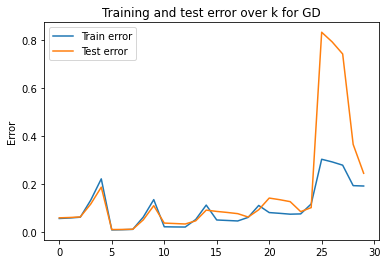

In [60]:
number_of_el = range(len(K_elements_map) * len(lambdas))
plt.plot(number_of_el, train_errors_gd, label = "Train error")
plt.plot(number_of_el, test_errors_gd, label = "Test error")
plt.legend()
plt.title("Training and test error over k for GD")
plt.ylabel("Error")
plt.show()

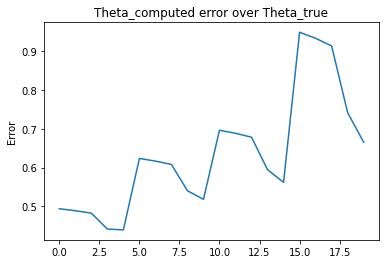

In [61]:
number_of_el = range(len(thetas_error_map_gd))
plt.plot(number_of_el, thetas_error_map_gd)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

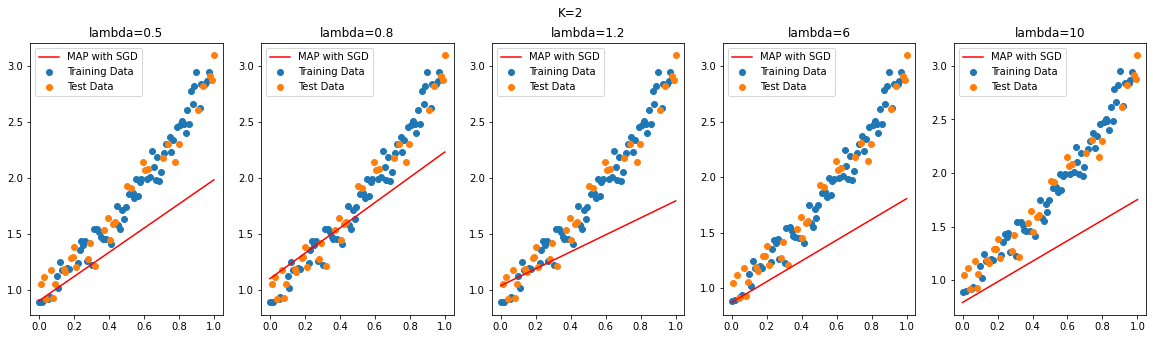

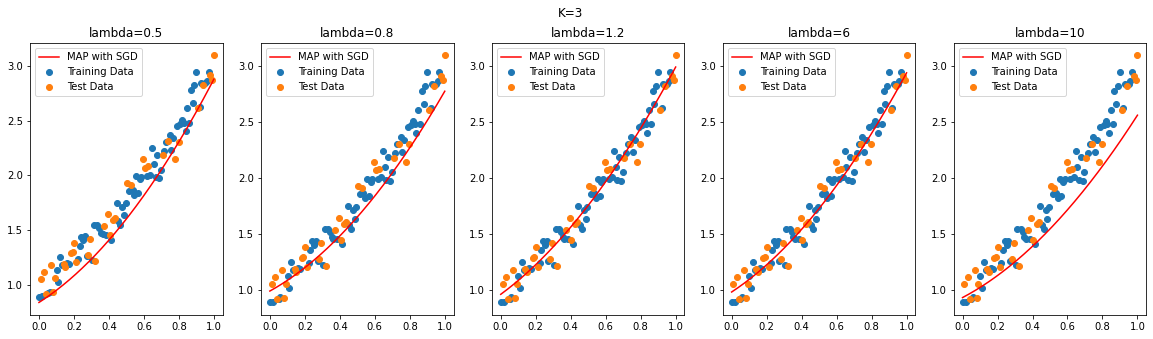

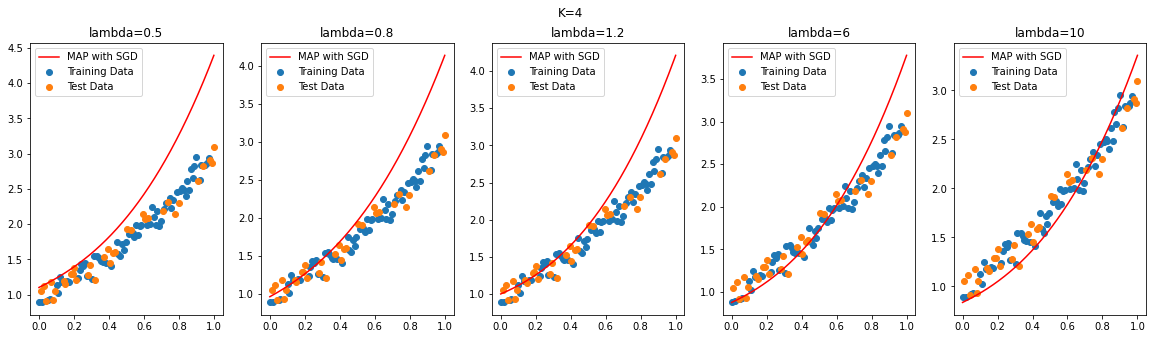

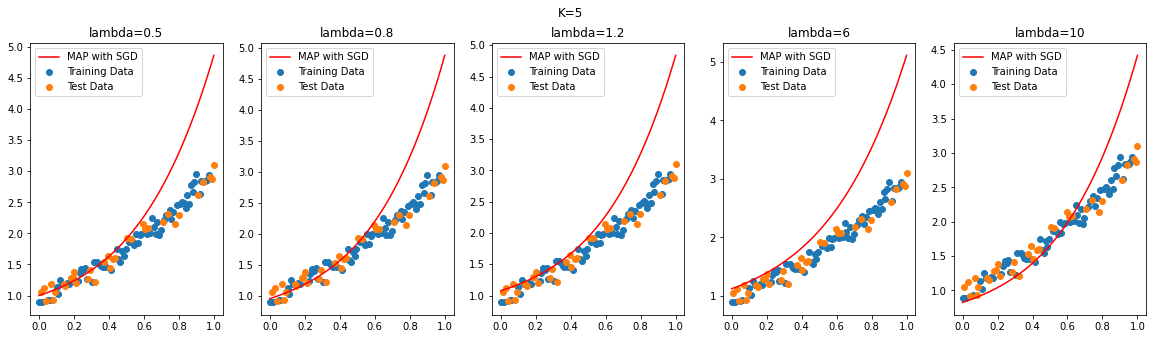

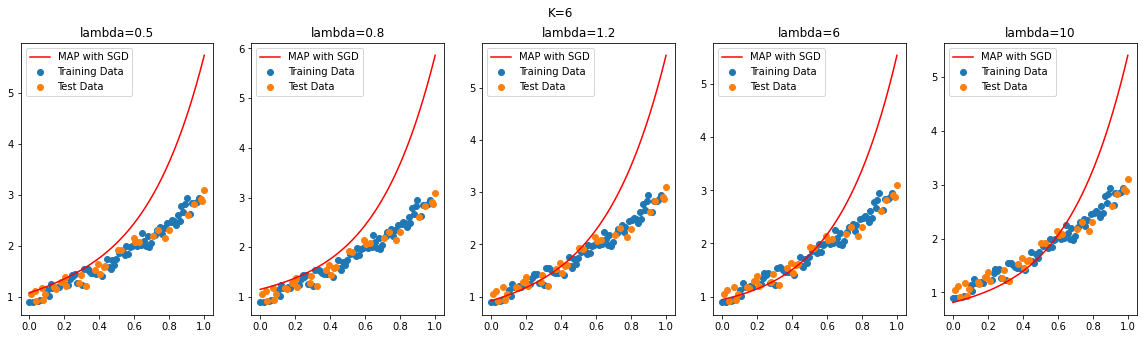

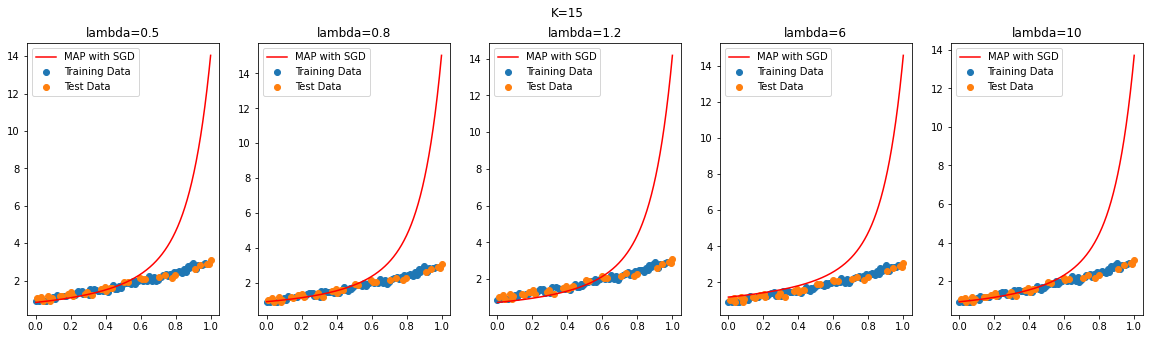

In [62]:
for i in range(len(K_elements_map)):
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"K={K_elements_map[i]}")
    for j in range(len((lambdas))):
      current_theta = thetas_map_sgd[i][j]
      X_plot = np.linspace(a, b, 1000)
      Y_plot = compute_f_theta(X_plot, K_elements_map[i], current_theta)
      plt.subplot(1, 5, j+1)
      plt.plot(X_plot, Y_plot, label=f"MAP with SGD", color="red")
      plt.scatter(Xtrain, Ytrain, label= "Training Data")
      plt.scatter(Xtest, Ytest, label="Test Data")
      plt.title(f"lambda={lambdas[j]}")
      plt.legend() 

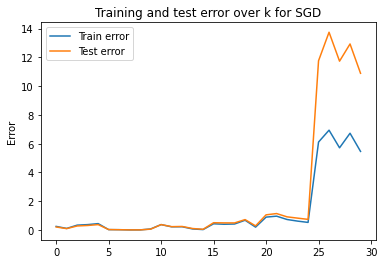

In [63]:
number_of_el = range(len(K_elements_map) * len(lambdas))
plt.plot(number_of_el, train_errors_sgd, label = "Train error")
plt.plot(number_of_el, test_errors_sgd, label = "Test error")
plt.legend()
plt.title("Training and test error over k for SGD")
plt.ylabel("Error")
plt.show()

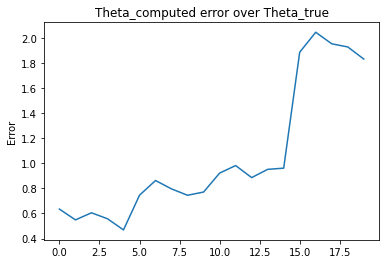

In [64]:
number_of_el = range(len(thetas_error_map_sgd))
plt.plot(number_of_el, thetas_error_map_sgd)
plt.title("Theta_computed error over Theta_true")
plt.ylabel("Error")
plt.show()

In [65]:
print("Some comparison of errors on test set:")
i = len(thetas_mle_ne) - 1
print(f"Error for k={K_elements_mle[i]} and MLE:")
print(f"NE: {avg_error(thetas_mle_ne[i], Dtest)}")
print(f"GD: {avg_error(thetas_mle_gd[i], Dtest)}")
print(f"SGD: {avg_error(thetas_mle_sgd[i], Dtest)}")

print("\n")

print("Some comparison of errors on test set:")
i = len(thetas_map_ne) - 1
print(f"Error for k={K_elements_map[i]} and MAP: \n")
print(f"NE:")
for j, lam in enumerate(lambdas):
  print(f"lambda={lam}")
  current_theta = thetas_map_ne[i][j]
  print(f" {avg_error(current_theta, Dtest)}")

print("\n")

print(f"GD:")
for j, lam in enumerate(lambdas):
  print(f"lambda={lam}")
  current_theta = thetas_map_gd[i][j]
  print(f" {avg_error(current_theta, Dtest)}")

print("\n")

print(f"SGD:")
for j, lam in enumerate(lambdas):
  print(f"lambda={lam}")
  current_theta = thetas_map_sgd[i][j]
  print(f" {avg_error(current_theta, Dtest)}")

Some comparison of errors on test set:
Error for k=15 and MLE:
NE: 0.07203728126425249
GD: 0.9063621538482983
SGD: 12.442416591389401


Some comparison of errors on test set:
Error for k=15 and MAP: 

NE:
lambda=0.5
 0.01289769836842379
lambda=0.8
 0.013680034002202295
lambda=1.2
 0.014800136418959987
lambda=6
 0.029514569927664346
lambda=10
 0.04250052401276287


GD:
lambda=0.5
 0.8339323967032454
lambda=0.8
 0.7936363038171799
lambda=1.2
 0.7433435035148508
lambda=6
 0.366309770046482
lambda=10
 0.24577901614751627


SGD:
lambda=0.5
 11.766777245740299
lambda=0.8
 13.746911208269252
lambda=1.2
 11.737525135284175
lambda=6
 12.932393228104402
lambda=10
 10.894517734895338


In [66]:
print("Some comparison of thetas computed by different methods:\n")
i_k_mle = 2
i_k_map = 1
i_lam = 0

print(f"K={K_elements_mle[i_k_mle]} with MLE")
print(f"Theta with NE = {thetas_mle_ne[i_k_mle]}")
print(f"Theta with GD = {thetas_mle_gd[i_k_mle]}")
print(f"Theta with SGD = {thetas_mle_sgd[i_k_mle]}")

print("\n")

print(f"K={K_elements_mle[i_k_mle]} with MAP and lambda={lambdas[i_lam]}")
print(f"Theta with NE = {thetas_map_ne[i_k_map][i_lam]}")
print(f"Theta with GD = {thetas_map_gd[i_k_map][i_lam]}")
print(f"Theta with SGD = {thetas_map_sgd[i_k_map][i_lam]}")

Some comparison of thetas computed by different methods:

K=3 with MLE
Theta with NE = [0.95261622 1.16101762 0.88783045]
Theta with GD = [0.99354048 1.00697928 1.00626393]
Theta with SGD = [1.02063592 0.9029435  1.0333602 ]


K=3 with MAP and lambda=0.5
Theta with NE = [0.97828183 1.08521164 0.90765109]
Theta with GD = [0.99325391 0.99009663 0.9813581 ]
Theta with SGD = [0.83592802 1.01477239 1.02818803]
